# Алгоритм Гровера

Предположен, нам дана функция $F:X\rightarrow \{0, 1\}$. 

Если существует только один единственный аргумент $x\in X$, для которого $F(x)=1$, то на классическом компьютере нам потребуется $\mathcal{O}(|X|)$ проверок, чтобы найти его. То есть в худшем случае мы просмотрим все зачения $x$ из $X$, и искомое будет последним в нашем переборе. Даже если таких аргументов больше -- поиск хотя бы одного из них тоже будет занимать линейное время.

В квантовых системах мы можем таким образом определить функцию $\tilde{F}$, чтобы она помечала искомые аргументы с помощью фазового множителя (-1). Вспомним, что в квантовых системах функции можно вызывать для суперпозиции [всех] аргументов. Поэтому, если мы вызовем $\tilde{F}(H^{\otimes N})$, то в получившейся суперпозиции все состояния, которые не удовлетворяют функции, будут иметь амплитуду $+1*\frac{1}{\sqrt{2^N}}$, а те, которые удовлетворяют -- $-1*\frac{1}{\sqrt{2^N}}$.

Когда мы помечаем аргументы знаком минус, мы делаем ровно то, что делали а функции `inverse()` в задании про обращение относительно среднего.

Используя специально подготовленную $\tilde{F}$, мы сможем найти искомый $x$ за $\mathcal{O}(\sqrt{|X|})$. И даже если их несколько -- то какой-то из них.

Основные шаги алгоритма:
1. Делаем из обычного оракула фазовый
2. Имлементируем диффузор Гровера
3. Определяемся с количеством итераций алгоритма. Повторяем.

Начнём в первого пункта.

## Фазовый оракул

## Constructing the Gorver Oracle

Детали этого метода описаны в материале [qiskit texbook](https://qiskit.org/textbook/ch-algorithms/grover.html). Там показана идея, как сконвертировать "классическую" функцию оракула $F$ в функцию нужного нам (фазового) вида. Механизм, на которые опирается этот метод -- *Phase Kickback*.

Напомним, что **Phase Kickback** изменяет фазу у амплитуды **контролирующего** кубита или даже регистра, если управляемый кубит находится в собственном состоянии котролируемого оператора.

В случаем с оракулом, предполагаемся, что вы можете представить его в таком виде:

![](https://qiskit.org/textbook/ch-algorithms/images/grover_boolean_oracle.svg)

Собственные векторы и значения оператора $X$ нам уже хорошо известны. Поэтому мы заготовим $|-\rangle$ в управляемом кубите... и забудем про него.

![](https://qiskit.org/textbook/ch-algorithms/images/grover_phase_oracle.svg)

Давайте сконвертируем уже знакомый нам по форме оракул.

```
if (|x> >= 6) { 
    |y> = X|y> 
}
```

в фазовый вид. 
Для начала напишем его полностью:

In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, BasicAer

def get_oracle():
    x = QuantumRegister(4, 'x')
    y = QuantumRegister(1, 'y')
    qc = QuantumCircuit(x, y, name="oracle")
    
    #######
    ## x -= 4 
    qc.x(x[2])
    qc.cx(x[2], x[3])
    ## x -= 2
    qc.x(x[1])
    qc.cx(x[1], x[2])
    qc.ccx(x[1], x[2], x[3])

    qc.x(x[3])
    qc.cx(x[3], y[0])
    qc.x(x[3])
    
    ## x += 2
    qc.ccx(x[1], x[2], x[3])
    qc.cx(x[1], x[2])
    qc.x(x[1])
    
    #######
    ## x += 4 
    qc.cx(x[2], x[3])
    qc.x(x[2])
    
    return qc

Проверим, что он работает "классически".

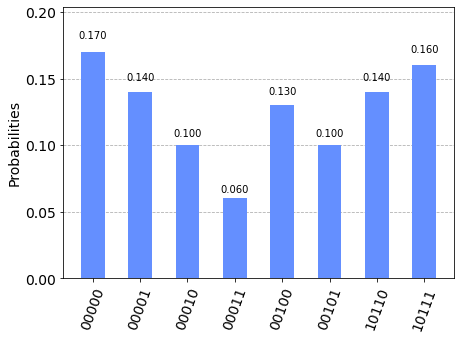

In [13]:
qc = QuantumCircuit(5)
qc.h(range(3))
qc.append(get_oracle(), range(5))
qc.measure_all()

job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=100)
counts = job.result().get_counts(qc)
plot_histogram(counts)

А теперь проверим, как это выглядит в фазовой форме:

In [22]:
import numpy as np

qc = QuantumCircuit(5)
qc.h(range(3))

# подготовим управляемые кубит в |->
qc.x(4)
qc.h(4)

qc.append(get_oracle(), range(5))

# вернём его в 0
qc.h(4)
qc.x(4)


job = execute(qc, BasicAer.get_backend('statevector_simulator'))
vector = job.result().get_statevector()

print(np.round_(vector.real, 4))

[ 0.3536  0.3536  0.3536  0.3536  0.3536  0.3536 -0.3536 -0.3536  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.    ]


## Количество итерация

Ранее мы видели, что обращение относительно среднего даёт нам периодическую функцию. На пике этой функции можной поймать самую "выгодную" разницу между всеми элементами, и "помеченными". Но как поймать такой пик?

Если в списке из $ N $ элементов (=квантовых состояний) помечен всего один (=одно квантовое состояние), тогда помеченный элемент (состояние) будет иметь наибольшую амплитуду после $ \pi \dfrac{\sqrt{N}}{4} $ итераций алгоритма Гровера.

Если же помечены $k$ элементов, тогда оптимальные значения достигаются после $ \pi \dfrac{\sqrt{\frac{N}{k}}}{4} $ повторений.

Если же $k$ неизвестно, то нам придётся его подбирать. Один из способов это сделать -- запустить алгоритм  $ \pi \dfrac{\sqrt{\frac{N}{1}}}{4}, \pi \dfrac{\sqrt{\frac{N}{2}}}{4}, \pi \dfrac{\sqrt{\frac{N}{4}}}{4}, \pi \dfrac{\sqrt{\frac{N}{8}}}{4}, \ldots $ раз. 

И даже в этом случае число повторений алгоритма будет пропорционально $ \pi \dfrac{\sqrt{N}}{4} $: $ O \Big( \pi \dfrac{\sqrt{N}}{4} \Big) $. А значит, он асимптотически быстрее, чем метод простого перебора.

Давайте, наконец, реализуем это в виде алгоритма, и запустим на настоящем квантовом компьютере!

## Полная имплементация алгоритма Гровера

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, BasicAer

In [29]:
from qiskit.circuit.library import ZGate
ccz = ZGate().control(2)

def get_diffusor():
    qdiff = QuantumRegister(3)
    diffusor = QuantumCircuit(qdiff, name="IoM")
    diffusor.h(qdiff)
    diffusor.x(qdiff)
    diffusor.append(ccz, qdiff)
    diffusor.x(qdiff)
    diffusor.h(qdiff)
    return diffusor

print(get_diffusor())

        ┌───┐┌───┐   ┌───┐┌───┐
q335_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
        ├───┤├───┤ │ ├───┤├───┤
q335_1: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
        ├───┤├───┤ │ ├───┤├───┤
q335_2: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
        └───┘└───┘   └───┘└───┘


In [53]:
data = QuantumRegister(3, name="data")
sign = QuantumRegister(1, name="sign")
ancilla = QuantumRegister(1, name="ancilla")
result = ClassicalRegister(3, name="result")
qc = QuantumCircuit(data, sign, ancilla, result)

oracle = get_oracle()
diffusor = get_diffusor()

# подготовим суперпозицию неотрицательных чисел 0..7
qc.h(data)

# подготовим |-> во вспомогательном кубите
qc.x(ancilla)
qc.h(ancilla)

qc.barrier()

# сколько нам нужно итераций?
k = 2
N = 2 ** 3
N_ITERATIONS = int((np.pi / 4) * (N / k) ** .5)
print("Итераций:", N_ITERATIONS)

for i in range(N_ITERATIONS):
    # добавим оракула
    qc.append(oracle, data[:] + sign[:] + ancilla[:])
    qc.barrier()
    # добавим обращение относительно среднго
    qc.append(diffusor, data)
    qc.barrier()

qc.measure(data, result)
qc.draw()

Итераций: 1


┌───┐      ░ ┌─────────┐ ░ ┌──────┐ ░ ┌─┐      
   data_0: ┤ H ├──────░─┤0        ├─░─┤0     ├─░─┤M├──────
           ├───┤      ░ │         │ ░ │      │ ░ └╥┘┌─┐   
   data_1: ┤ H ├──────░─┤1        ├─░─┤1 IoM ├─░──╫─┤M├───
           ├───┤      ░ │         │ ░ │      │ ░  ║ └╥┘┌─┐
   data_2: ┤ H ├──────░─┤2 oracle ├─░─┤2     ├─░──╫──╫─┤M├
           └───┘      ░ │         │ ░ └──────┘ ░  ║  ║ └╥┘
   sign_0: ───────────░─┤3        ├─░──────────░──╫──╫──╫─
           ┌───┐┌───┐ ░ │         │ ░          ░  ║  ║  ║ 
ancilla_0: ┤ X ├┤ H ├─░─┤4        ├─░──────────░──╫──╫──╫─
           └───┘└───┘ ░ └─────────┘ ░          ░  ║  ║  ║ 
 result: 3/═══════════════════════════════════════╩══╩══╩═
                                                  0  1  2

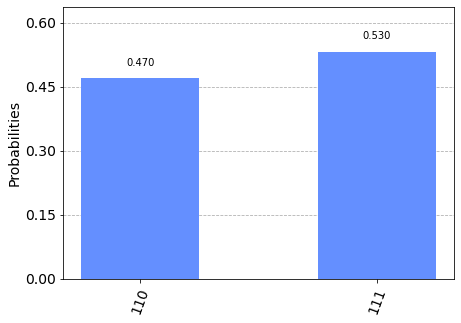

In [54]:
job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=100)
counts = job.result().get_counts(qc)
plot_histogram(counts)

## Давайте обсудим результат
1. Как проинтерпретировать этот результат?
2. Сколько на самом деле простейших действий мы сделали?
3. Сколько раз мы запустили квантовую программу?
4. Что будет если запустить её всего один раз?

Глубина (depth) контура: 41


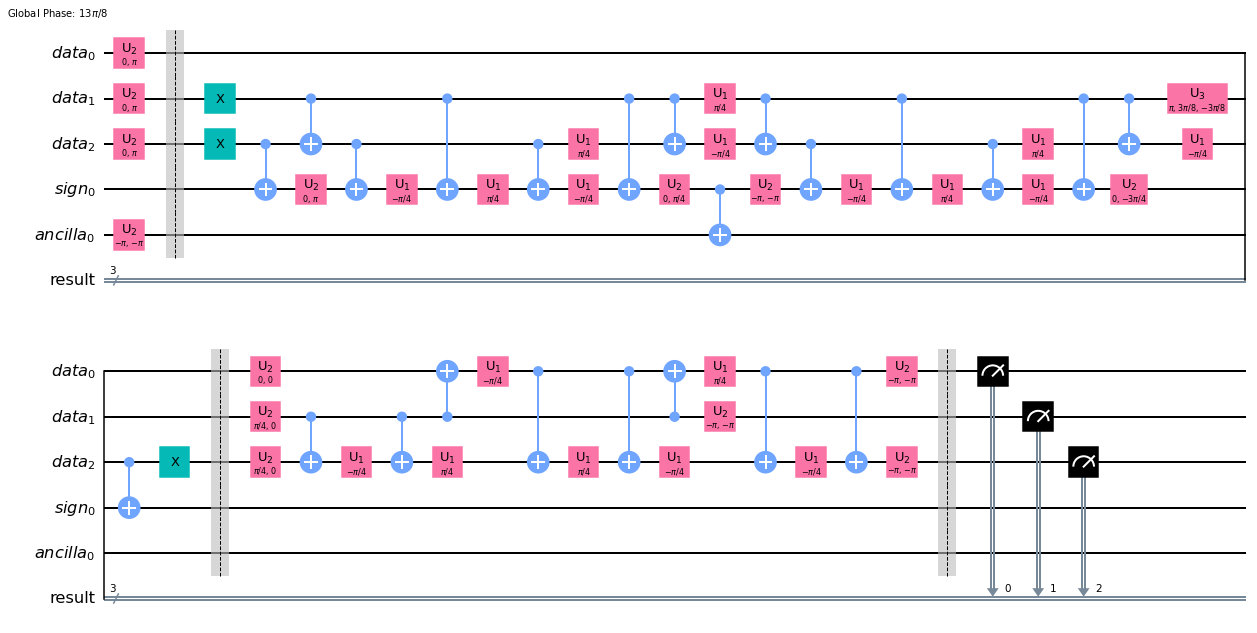

In [55]:
from qiskit.compiler import transpile
# запустите строчку, чтобы увидеть, какие на самом деле примитивные
# операции совершал симулятор:

qct = transpile(qc, BasicAer.get_backend('qasm_simulator'))
print("Глубина (depth) контура:", qct.depth())
qct.draw(output='mpl')

## ... и наконец запустим на настоящем квантовом компьютере!

Если вы ещё этого не сделали - зайдите на https://quantum-computing.ibm.com/account, зарегистрируйтесь и получите токен.

In [56]:
from qiskit import IBMQ
# если запускаете первый раз - подставьте токен, если не первый - можно убрать эту строку
# IBMQ.save_account("TOKEN")

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

available_cloud_backends = provider.backends() 
for backend in available_cloud_backends:
    status = backend.status()
    nqubits = backend.configuration().n_qubits
    is_operational = status.operational
    jobs_in_queue = status.pending_jobs
    if is_operational and 'ibmq_' in str(backend):
        print(f"{nqubits} Qubits {backend} has a queue={jobs_in_queue}")

ibmqfactory.load_account:WARNING:2021-12-03 12:56:24,415: Credentials are already in use. The existing account in the session will be replaced.


32 Qubits ibmq_qasm_simulator has a queue=9
1 Qubits ibmq_armonk has a queue=1
5 Qubits ibmq_santiago has a queue=1948
5 Qubits ibmq_bogota has a queue=16
5 Qubits ibmq_lima has a queue=20
5 Qubits ibmq_belem has a queue=12
5 Qubits ibmq_quito has a queue=20
5 Qubits ibmq_manila has a queue=34


Выберите наименее загуженный 5-кубитный компьютер. Когда я запускал этот код, это был `ibmq_belem`.

79


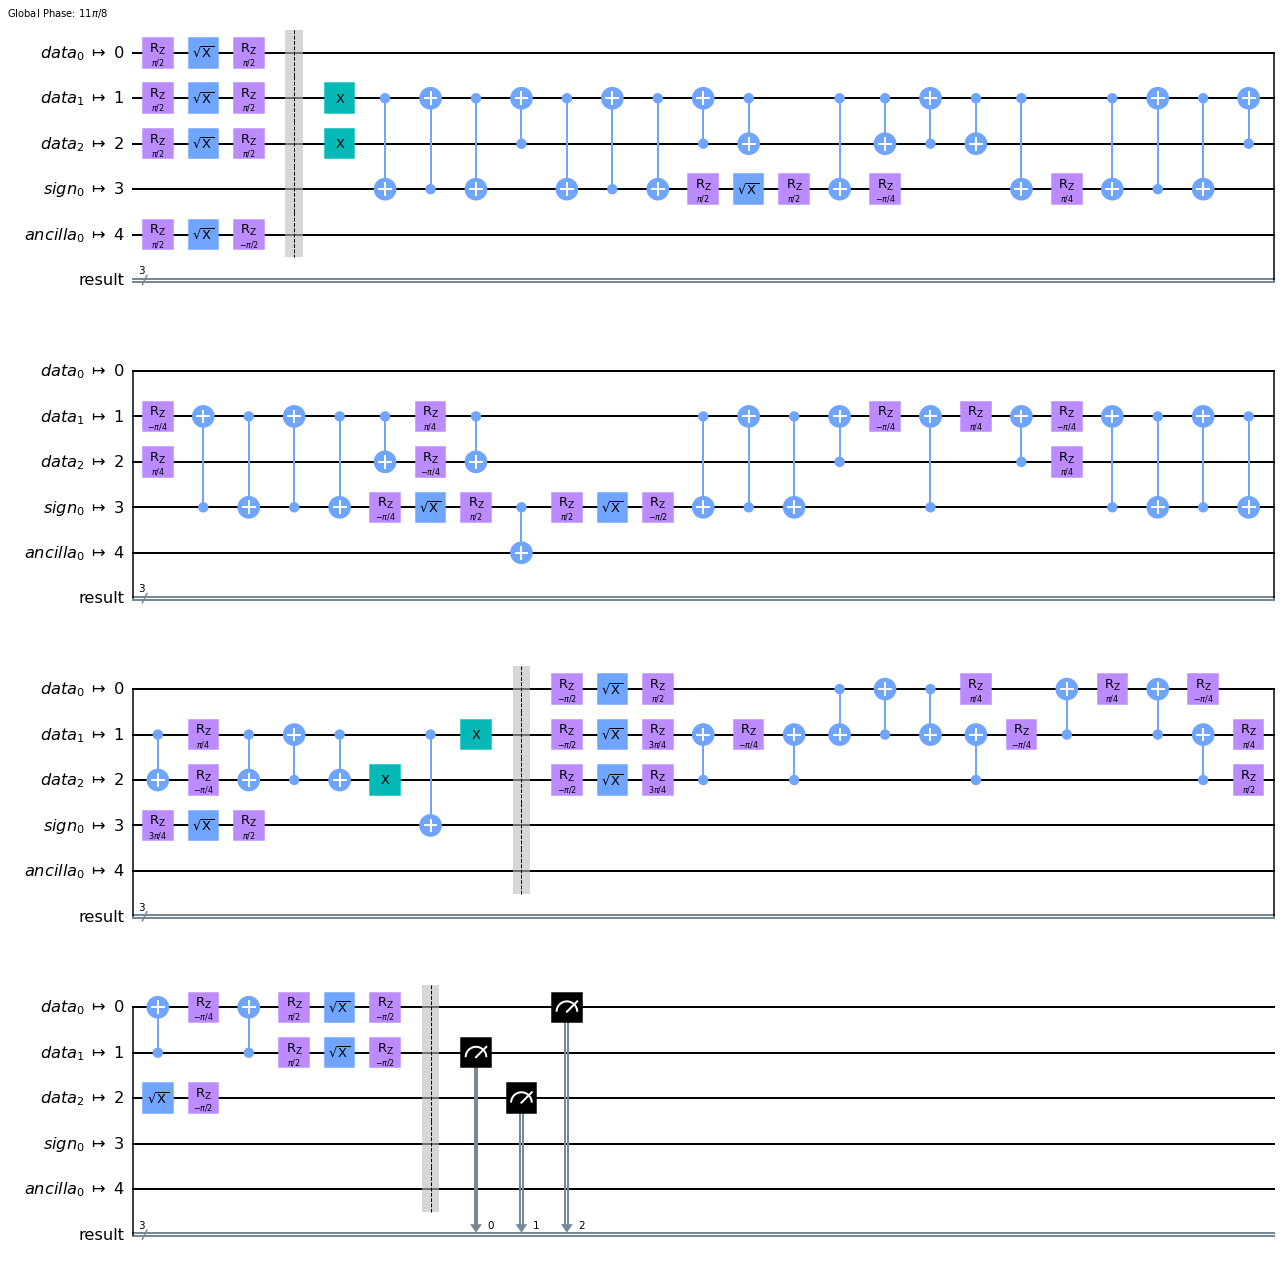

In [58]:
backend = provider.get_backend('ibmq_belem')
# как будет выглядеть наша программа на этом компьютере?
qct = transpile(qc, backend)
print(qct.depth())
qct.draw(output='mpl')

In [ ]:
# запускаем задачу на компьютере. Она будет проверена и поставлена в очередь.
job = backend.run(qct)

from qiskit.tools.monitor import job_monitor
# монитор будет дожидаться успешного статуса
job_monitor(job)

print(job.status())

# покажем гистограмму!
counts = job.result().get_counts()
plot_histogram(counts)

Job Status: job is queued (8)     